In [1]:
!add-apt-repository -y ppa:alex-p/tesseract-ocr-devel
!apt-get update
!apt-get install tesseract-ocr
!pip install pytesseract

Repository: 'deb https://ppa.launchpadcontent.net/alex-p/tesseract-ocr-devel/ubuntu/ jammy main'
Description:
This PPA contains an OCR engine - libtesseract and a command line program - tesseract. The development version available here (currntly 5.0.0 ) is better in many aspects (functionality, speed, stability) but is not 100 % API compatible with version 4.0. Tesseract 4 added a new neural net (LSTM) based OCR engine which is focused on line recognition, but also still supports the legacy Tesseract OCR engine of Tesseract 3 which works by recognizing character patterns. Compatibility with Tesseract 3 is enabled by using the Legacy OCR Engine mode (--oem 0). It also needs traineddata files which support the legacy engine, for example those from the tessdata repository. Tesseract has unicode (UTF-8) support, and can recognize more than 100 languages "out of the box". Tesseract supports various output formats: plain text, hOCR (HTML), PDF, invisible-text-only PDF, TSV. The master branch

In [22]:

from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

In [23]:
def plt_imshow(title, image):

	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [27]:

args = {
	"image": "/content/Africa-HIV.jpg",
	"output": "results.csv",
	"min_conf": 0,
	"dist_thresh": 25.0,
	"min_size": 2,     #2 columns
}

In [28]:

np.random.seed(42)


image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

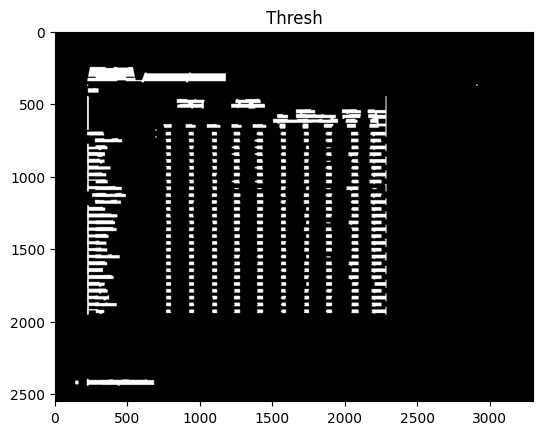

In [6]:


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)


grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")


grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt_imshow("Thresh", thresh)

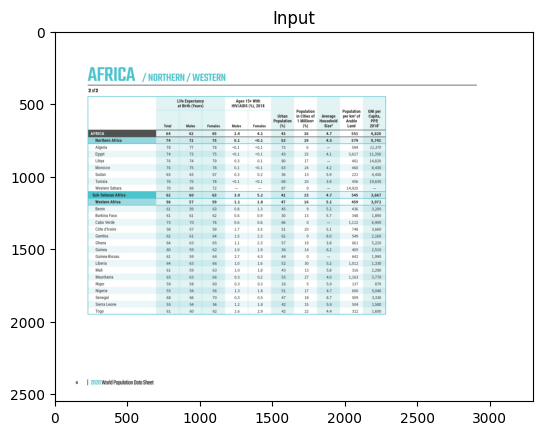

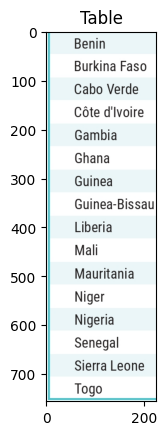

In [29]:

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
tableCnt = max(cnts, key=cv2.contourArea)


(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]


plt_imshow("Input", image)
plt_imshow("Table", table)

In [9]:

options = "--psm 6"
results = pytesseract.image_to_data(
	cv2.cvtColor(table, cv2.COLOR_BGR2RGB),
	config=options,
	output_type=Output.DICT)


coords = []
ocrText = []


for i in range(0, len(results["text"])):
	
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]

	text = results["text"][i]
	conf = int(float(results["conf"][i]))

	if conf > args["min_conf"]:
		
		coords.append((x, y, w, h))
		ocrText.append(text)

In [10]:

xCoords = [(c[0], 0) for c in coords]


clustering = AgglomerativeClustering(
	n_clusters=None,
	affinity="manhattan",
	linkage="complete",
	distance_threshold=args["dist_thresh"])
clustering.fit(xCoords)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='manhattan', distance_threshold=25.0,
                        linkage='complete', n_clusters=None)

In [11]:

sortedClusters = []


for l in np.unique(clustering.labels_):

	idxs = np.where(clustering.labels_ == l)[0]

	if len(idxs) > args["min_size"]:
		
		avg = np.average([coords[i][0] for i in idxs])
		sortedClusters.append((l, avg))

sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [12]:

for (l, _) in sortedClusters:
	
	idxs = np.where(clustering.labels_ == l)[0]

	
	yCoords = [coords[i][1] for i in idxs]
	sortedIdxs = idxs[np.argsort(yCoords)]

	
	color = np.random.randint(0, 255, size=(3,), dtype="int")
	color = [int(c) for c in color]

	for i in sortedIdxs:
		
		(x, y, w, h) = coords[i]
		cv2.rectangle(table, (x, y), (x + w, y + h), color, 2)

	
	cols = [ocrText[i].strip() for i in sortedIdxs]
	currentDF = pd.DataFrame({cols[0]: cols[1:]})

	
	df = pd.concat([df, currentDF], axis=1)

In [13]:

df.fillna("", inplace=True)
print(tabulate(df, headers="keys", tablefmt="psql"))

+----+---------------+----------+
|    | Benin         | Verde    |
|----+---------------+----------|
|  0 | Burkina       | d'Ivoire |
|  1 | Cabo          | Leone    |
|  2 | Cote          |          |
|  3 | Gambia        |          |
|  4 | Ghana         |          |
|  5 | Guinea        |          |
|  6 | Guinea-Bissau |          |
|  7 | Liberia       |          |
|  8 | Mali          |          |
|  9 | Mauritania    |          |
| 10 | Niger         |          |
| 11 | Nigeria       |          |
| 12 | Senegal       |          |
| 13 | Sierra        |          |
| 14 | Togo          |          |
+----+---------------+----------+


[INFO] saving CSV file to disk...


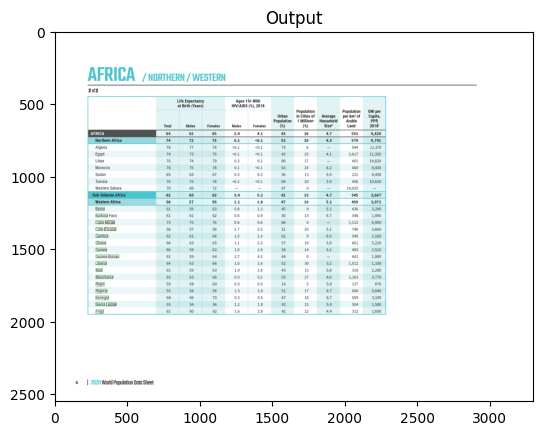

In [14]:

print("[INFO] saving CSV file to disk...")
df.to_csv(args["output"], index=False)


plt_imshow("Output", image)

In [ ]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image to be OCR'd")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output CSV file")
# ap.add_argument("-c", "--min-conf", type=int, default=0,
# 	help="minimum confidence value to filter weak text detection")
# ap.add_argument("-d", "--dist-thresh", type=float, default=25.0,
# 	help="distance threshold cutoff for clustering")
# ap.add_argument("-s", "--min-size", type=int, default=2,
# 	help="minimum cluster size (i.e., # of entries in column)")
# args = vars(ap.parse_args())

In [ ]:
def extract_table_data(image_path):
   
    image = Image.open(image_path)

 
    ocr_text = pytesseract.image_to_string(image)

    
    table_data = [row.split('\t') for row in ocr_text.split('\n') if row]

    return table_data


image_path = '/content/Americas-HIV.jpg'
table_data = extract_table_data(image_path)


for row in table_data:
    print(row)